In [2]:
import shelve
import io
import scipy.io
from scipy.io import savemat
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets, decomposition
import numpy as np
import gc
from datetime import datetime
import datetime as dt
import dateparser
from ipykernel import kernelapp as app
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from operator import itemgetter
import folium
from folium.plugins import HeatMap
import Instalib as IL
import Instaplot as IP
import math
import re
import string
import emoji
import pickle
import scipy.io
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
import sktensor
import geopy.distance
from itertools import groupby
import ncp
from datetime import timedelta
from dateutil.relativedelta import *
import os
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import nltk.data #
nltk.download('punkt')
from nltk.stem.snowball import FrenchStemmer
italian_stemmer = nltk.stem.SnowballStemmer('italian')
english_stemmer = nltk.stem.SnowballStemmer('english')
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import langid
langid.set_languages(['it', 'en'])  # ISO 639-1 codes
import importlib


[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2019-03-12 12:19:25,754 : INFO : initializing identifier


# Open the file and have a first look

Read the data and concatenate in a single DataFrame file, basic file format for pandas. It's a 2-D object, tabular file with labeled rows and columns, built from a dictionary or such. 

More info about it here: https://pandas.pydata.org/pandas-docs/stable/10min.html

Make our life easier by matching the Torino labels with the Marseille ones and convert strings to datetime

In [2]:
df_users_list=[d for d in os.listdir('DF/USERS') if 'dataframe' in d]

df_new=pd.read_pickle('DF/USERS/'+df_users_list[0])
#df_new=df_new.rename(columns = {'caption':'text','taken_at_timestamp':'date'})
df_new.head()

for df in df_users_list[1:]:
    df_new=pd.concat([df_new,pd.read_pickle('DF/USERS/'+df)])

KeyboardInterrupt: 

In [ ]:
df_new.shape

In [93]:
df_users_list=[d for d in os.listdir('DF/USERS') if 'dataframe' in d]

df_new=pd.read_pickle('DF/USERS/'+df_users_list[0])
#df_new=df_new.rename(columns = {'caption':'text','taken_at_timestamp':'date'})
df_new.head()

for df in df_users_list[1:]:
    df_new=pd.concat([df_new,pd.read_pickle('DF/USERS/'+df)])

user_loc_dict=pickle.load(open('user_loc_dict.pkl','rb'))

#users=df_new.user_id.tolist()

#for i in range(0, len(users)):
#    if users[i] not in user_loc_dict.keys():
#        users[i]=0
#df_new.user_id=users
#df_new=df_new[df_new.user_id!=0]

#df_new['user_loc']=df_new['user_id'].apply(lambda x : max(user_loc_dict[x],key=itemgetter(1))[0])

KeyboardInterrupt: 

In [95]:
def to_coords(user_loc):
    if 'km' in user_loc:
        user_loc=[float(i) for i in user_loc.split(',')[0:2]]
        return user_loc
    else:
        return [float(i) for i in user_loc[1:-1].split(',')]

In [96]:
df_new['user_loc']=df_new['user_loc'].apply(to_coords)

KeyError: 'user_loc'

In [97]:
df_new.groupby('lang').count().text.sort_values()

lang
bn           1
bo           1
ur           1
si           1
ka           1
fa           1
iw           9
th          13
bg          28
sr          45
zh         119
hi         200
ar         223
uk         269
el         388
hu         393
is         402
sl         544
vi         713
lv         715
sv         763
ko         860
no         981
da         998
cy        1056
tr        1071
cs        1216
fi        1421
eu        1555
pl        1555
nl        1578
ru        2268
lt        2400
et        2798
de        3633
ht        3782
ro        4410
tl        4948
ca        5481
in        7585
ja        8271
pt       18125
fr       27252
es       60510
und     161533
en      359597
it     1572036
Name: text, dtype: int64

In [98]:
#df_new.rename(columns={'created_at':'date', 'location':'loc_field','user_loc':'coords'},inplace=True)
df_new.rename(columns={'created_at':'date', 'location':'loc_field'},inplace=True)
df_new.set_index('user_id',inplace=True)

In [99]:
importlib.reload(IL)
list_dates, Histo = IL.N_posts(df_new, debug=False)
Npostslog=[np.log10(H) for H in Histo]
Nposts=[H for H in Histo]

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


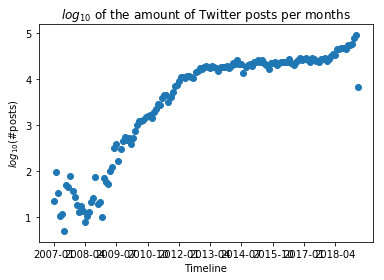

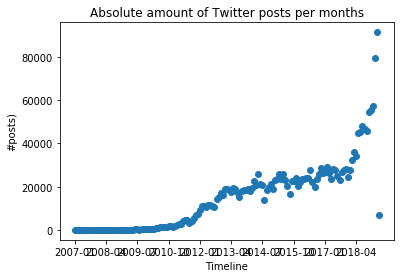

In [100]:
if 'Figures' not in os.listdir('.') and False:
    os.mkdir('Figures')
    os.mkdir('Figures/Shape')
    os.mkdir('Figures/Shape/Spatial')
    os.mkdir('Figures/Shape/Temporal')
plt.figure()
plt.scatter(list_dates, Npostslog)
plt.xticks(list_dates[0::15])
plt.ylabel(r'$log_{10}$(#posts)')
plt.xlabel('Timeline')
plt.title(r'$log_{10}$ of the amount of Twitter posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_logN.pdf')
plt.show()
plt.figure()
plt.scatter(list_dates, Nposts)
plt.xticks(list_dates[0::15])
plt.ylabel('#posts)')
plt.xlabel('Timeline')
plt.title('Absolute amount of Twitter posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_N.pdf')
plt.show()

# Let's refine the DataFrame

In [101]:
pickle.dump(df_new, open('df_new_chkpt1.pkl', 'wb'))

Build the frame and the grid. $$x_{min/max}=longitude_{min/max}$$ and conversely for y and latitude.

In [12]:
df_new['lat']=[e[0] for e in df_new['coords']]
df_new['lon']=[e[1] for e in df_new['coords']]

In [13]:
# Attention problème d'arrondi lors du passage de Coord à (lat,lon)
step_m=0.5
lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
print (number_lats, number_lon)
df_new.coords=df_new.coords.apply(tuple)

27.000000000000988 21.00000000000005


In [27]:
lat1,lon1, lat2,lon2

(45.026999999999994, 7.589198154934451, 45.13504497, 7.71268637)

### Checkpoint 2

In [14]:
#pickle.dump(df_new, open('df_new_chkpt2.pkl', 'wb'))
#df_new=pd.read_pickle('df_new_chkpt2.pkl')

# Time to clean the text

But first make a copy before we do anything stupid

In [116]:
df_new_save=df_new.copy()
#df_new=df_new_save.copy()

This methods works only on unicode text. So we need to use the function x.decode('utf-8') to convert all strings in the 'text' field to unicode objects.

In [102]:
#importlib.reload(IL)
df_new=IL.text_processing(df_new)
df_new.drop(['text'],axis=1,inplace=True)
df_new=df_new.rename(columns = {'text_new':'text'})
df_new=df_new[df_new.text!='']
df_new.text=[e.decode('utf-8') for e in df_new.text.tolist()]
#df_new['coordsbin'] = list(zip(df_new.latbin,df_new.lonbin))
#print len(df_new_save.text.tolist()) - len(df_new.text.tolist()), 'posts deleted in the process'
df_new.head()

,rt,date,lang,loc_field,text
user_id,,,,,
611727619,False,2019-03-05 16:01:07+00:00,it,Torino,ENIGMA CARAVAGGIO di Progetto Zoran To ven e ...
611727619,False,2019-03-04 15:31:37+00:00,it,Torino,Due settimane a Mahavidya La forza e il miste...
611727619,False,2019-03-04 10:00:12+00:00,it,Torino,DEAR SEYMOUR di Alessia Ruffolo CANADA ven e ...
611727619,False,2019-03-01 07:00:23+00:00,it,Torino,METROPOLITAN ART WORKSHOP sab e dom marzo h ...
611727619,False,2019-02-20 08:00:19+00:00,it,Torino,RAgazze LADRE di Liberi Pensatori Paul Valéry ...


In [110]:
df_new.shape

(2261750, 5)

### Checkpoint 3

In [111]:
#And pickle it
#df_new.to_pickle('df_new_chkpt3.pkl')
#df_new=pd.read_pickle('df_new_chkpt3.pkl')

In [14]:
if True:
    #In case I'm not loading this since the beginning
    dict_coord_name= dict(zip(df_new.coords,df_new.name))
    dict_name_coord= dict(zip(df_new.name,df_new.coords))
    step_m=0.5
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)

Learn about how groupby does not returns a dataframe but only groups the data IN ORDER TO APPLY SOME FUNCTION to it here: https://pandas.pydata.org/pandas-docs/stable/groupby.html

In [112]:
df_new_index,df_new_nodup2=IL.indexed_dataframe(df_new,step_lon,step_lat,number_lats)

KeyError: 'coords'

In [18]:
print(len(set(df_new.coords.tolist())), 'different coords in the dataset')
print(len(set(df_new.coordsbin.tolist())), 'different bins in the dataset')

94 different coords in the dataset
61 different bins in the dataset


In [19]:
#Make an index of only the years + months and text of posts
df_new_index=df_new[['date','text','coordsbin']]
df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be

In [20]:
print(df_new_index.shape)
print(len(df_new_index.text.tolist()), 'posts in df_new_index')
print('among which',len(set(df_new_index.text.tolist())), 'are unique')

(563539, 5)
563539 posts in df_new_index
among which 502058 are unique


### Checkpoint 4

In [3]:
#And pickle it
#df_new_index.to_pickle('df_new_index_chkpt4.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt4.pkl')
#df_new=pd.read_pickle('df_new_chkpt3.pkl')


In [4]:
start=datetime(2007,1,1)
stop=datetime(2019,2,1)
flags=IL.TimeFlags(start,stop,'months',1)
slices=[(f,f+relativedelta(months=1)) for f in flags]

In [5]:
def to_datetime(ts):
    return datetime.utcfromtimestamp(int(ts.timestamp()))

In [6]:
df_new

,rt,date,lang,loc_field,text
user_id,,,,,
611727619,False,2019-03-05 16:01:07,it,Torino,ENIGMA CARAVAGGIO di Progetto Zoran To ven e ...
611727619,False,2019-03-04 15:31:37,it,Torino,Due settimane a Mahavidya La forza e il miste...
611727619,False,2019-03-04 10:00:12,it,Torino,DEAR SEYMOUR di Alessia Ruffolo CANADA ven e ...
611727619,False,2019-03-01 07:00:23,it,Torino,METROPOLITAN ART WORKSHOP sab e dom marzo h ...
611727619,False,2019-02-20 08:00:19,it,Torino,RAgazze LADRE di Liberi Pensatori Paul Valéry ...
611727619,False,2019-02-19 08:00:27,tr,Torino,ALL ABOUT THE HEART di Canan Yücel Pekiçten TU...
611727619,False,2019-02-18 19:00:50,it,Torino,RAgazze LADRE di Liberi Pensatori Paul Valéry ...
611727619,False,2019-02-11 10:37:01,it,Torino,Grazie a tutte le Artenaute alle tante persone...
611727619,False,2019-02-07 14:00:01,it,Torino,Mito e attualità s’incontrano in un racconto m...


In [9]:
df_new.date=df_new.date.apply(to_datetime)
df2=df_new[['text','date']]
df2=df2[df2.text!='']
df2['month']=df2.date.apply(lambda x : '-'.join(str(x.date()).split('-')[:-1])).tolist()

In [34]:
df3=pd.DataFrame(df2.groupby(['user_id','month']).apply(lambda x : x.sum()))
df4=df3.reset_index(level=[2])
df_classified=df4[df4.level_2=='text'].reset_index(level=[1]).pivot(columns='month',values=0).fillna('')

# Checkpoint 5 (2)

In [8]:
#And pickle it
#df_new.to_pickle('df_new_chkpt5.pkl')
#df_new_index.to_pickle('df_new_index_chkpt5.pkl')
#df_classified.to_pickle('df_classified_chkpt5.pkl')

#df_new=pd.read_pickle('df_new_chkpt5.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
#df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

ImportError: No module named managers

In [84]:
df_classified.shape

(1945, 147)

# Term vector building by NTF

Stemming = removing all suffixes in the word to keep only its root.

This part executes NMF on time slices of the data, to have an idea of what the output might be. It generates .mat files that can be used by matlab.

More about NMF here: https://scikit-learn.org/stable/modules/decomposition.html#nmf

More info about countvectorizer here: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

And about TfIdf: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

And about NMF:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [ ]:
#pickle.dump(df_classified, open('df_granularity.pkl','wb'))

In [7]:
#counts = vectorizer_s.fit_transform(list_reviews_all)
#pickle.dump(counts, open('counts_master.pkl','wb'))
#pickle.dump(counts, open('counts_master_noMon.pkl','wb'))
#pickle.dump(vectorizer_s, open('vec_s_master.pkl','wb'))
#counts = pickle.load( open( 'PKL_files/counts_master.pkl', "rb" ) )
#vectorizer_s = pickle.load( open( 'PKL_files/vec_s_master.pkl', "rb" ) )

/home/eartiges/.local/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lamiacitt', 'torino\xc3'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [216]:
#df_new=pd.read_pickle('df_new_chkpt5.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
#df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

In [45]:
if 1:
    step_m=.5
    start=datetime(2010,10,1)
    stop=datetime(2018,12,12)
    flags=IL.TimeFlags(start,stop,'months',1)
    slices=[(f,f+relativedelta(months=1)) for f in flags]
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
    print (number_lats, number_lon)
    #Make an index of only the years + months and text of posts
    gc.collect()
    list_date=list(set([e.date() for e in df_new.date.tolist()]))
    list_years=list(set([e.year for e in list_date]))
    list_months=list(set([e.month for e in list_date]))
    df_new_index=df_new[['date','text','coordsbin']]
    df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
    df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
    yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
    df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

28.000000000001027 25.000000000000025


/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [85]:
lang = detect("Ein, zwei, drei, vier")
# it for italian, en for english
class StemmedCountVectorizer(CountVectorizer):
    # This class is basically a CountVectorizer class that has been enhanced with a stemmer method.
    def build_analyzer(self):
        #Use super to access the method build_analyzer form the class CountVectorizer.
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        #return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        return lambda doc: ([self.stemmer(w) for w in analyzer(doc)])
    
    def stemmer(self, w):
        if langid.classify(w)=='it':
            return italian.stemmer(w)
        elif langid.classify(w)=='en':
            return english.stemmer(w)
        else:
            return w
        
    def language_detector(w):
        try:
            return langid.classify(w)[0]
        except LangDetectException:
            return 'emoji'
    

In [89]:
os.mkdir('tweets_per_month/')

In [90]:
# Write the montly tweets in files
for col in df_classified.columns[:-1]:
    f=open('tweets_per_month/{}.txt'.format(col), 'w')
    for t in df_classified[col].tolist():
        f.write(t+'\n')
    f.close()

In [93]:
import gensim
model_1= gensim.models.Word2Vec(IL.sentences,iter=1,workers=32,window=5)
#model_1.wv.most_similar('negro')

2019-03-11 10:59:04,095 : INFO : collecting all words and their counts
2019-03-11 10:59:04,096 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-11 10:59:04,203 : INFO : PROGRESS: at sentence #10000, processed 330990 words, keeping 80513 word types
2019-03-11 10:59:04,505 : INFO : PROGRESS: at sentence #20000, processed 1177644 words, keeping 217487 word types
2019-03-11 10:59:04,576 : INFO : PROGRESS: at sentence #30000, processed 1374365 words, keeping 245938 word types
2019-03-11 10:59:04,822 : INFO : PROGRESS: at sentence #40000, processed 2106287 words, keeping 347490 word types
2019-03-11 10:59:05,250 : INFO : PROGRESS: at sentence #50000, processed 3388443 words, keeping 504336 word types
2019-03-11 10:59:05,659 : INFO : PROGRESS: at sentence #60000, processed 4535100 words, keeping 635628 word types
2019-03-11 10:59:05,903 : INFO : PROGRESS: at sentence #70000, processed 5143128 words, keeping 704042 word types
2019-03-11 10:59:06,054 : INFO : P

2019-03-11 10:59:37,590 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-03-11 10:59:37,591 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-03-11 10:59:37,592 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-03-11 10:59:37,592 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-03-11 10:59:37,593 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-11 10:59:37,593 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-11 10:59:37,594 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-11 10:59:37,595 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-11 10:59:37,596 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-11 10:59:37,596 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-11 10:59:37,597 : INFO : worker thread finished; awaiting finish of 3 more thr

In [100]:
model_1.wv.most_similar(['torino'])

[('piemonte', 0.805525541305542),
 ('lamiatorino', 0.7813327312469482),
 ('italia', 0.7573343515396118),
 ('Porta', 0.735625147819519),
 ('igerstorino', 0.7334575057029724),
 ('Vittorio', 0.7289634943008423),
 ('Piazza', 0.7258557081222534),
 ('Palazzo', 0.7246009111404419),
 ('Castello', 0.7224732637405396),
 ('Torino', 0.7213664650917053)]

In [112]:
importlib.reload(IL)
start=30
stop=92
#MATLAB says up to 15 terms we still have a core consistency above 60% without sampling. 
#at 16, the CC already varies a lot (between 3 ad 50%)
#For sampled, up to 17 terms seems to be OK.
n_topics=15
n_features=5000

sampling=False
mat_export=True
seeded=False
expanded=False

seed='pittura'

#Filter out the monuments?
monuments=False

#df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

all_stopwords=IL.stopwords(monuments)

if seeded and not expanded:
    df_word2vec=IL.df_seeding(df_classified, seed)
    list_reviews_all=df_word2vec.result.tolist()
elif expanded:
    df_word2vec=IL.df_expanded_seeding(df_classified, seed,model=model_1)
    list_reviews_all=df_word2vec.result.tolist()
else:
    #pass
    list_reviews_all=pd.DataFrame(df_classified.apply(lambda x : ' '.join(x), axis=1))[0].tolist()
    
#Build the vectorizer and the list of all words in the dataset
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords)     
while '' in list_reviews_all:
    list_reviews_all.remove('')
while "" in list_reviews_all:
    list_reviews_all.remove("")

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [201]:
# Feed the vectorizer with all the words in the dataset. Counts is the tweet/term matrix.
# fit_transform: fit first (build the features list with the relevant words)
# then transform: build the tweet/term matrix with the relevant tokens.
name_matlab='CC_matlab/Matr{}_'.format(n_features)
snapshots=df_classified.columns.tolist()[0:-1]        
#For every snapshot taken
TF_IDFs=[]
ct=0
for month in snapshots:
    ct+=1
    This_Month=df_classified.fillna('')[month].tolist()
    # Learn the vocabulary dictionary and return term-document matrix.
    counts = vectorizer_new.transform(This_Month)
    #Transform a count matrix to a normalized tf-idf representation. 
    #(i.e terms with frequencies too hi or lo are removed)
    # Weights are indexed by (postID, term): weight
    tfidf = TfidfTransformer().fit_transform(counts)
    savemat(name_matlab+str(ct), {'tfidf':tfidf})
    TF_IDFs.append(tfidf)

In [204]:
"""returns the list of n_topics, their mean core consistencies and their variances."""
import importlib.machinery
matlab = importlib.machinery.SourceFileLoader('matlab',"/opt/anaconda/miniconda3/lib/python3.6/site-packages/matlab/__init__.py").load_module()
from matlab import engine
eng=matlab.engine.start_matlab()

In [157]:
#counts = vectorizer_s.fit_transform([''.join(list(set(df_toNTF[col].tolist()))) for col in df_toNTF.columns])
#vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 

list_CCs,TF_IDFs = IL.CC_matlab(df_toNTF.fillna(''),vectorizer_new,n_features,R_f=50, nb_s=5, path='CC_matlab/')
#list_mean_cc=[np.mean(d) for d in list_CCs[1:]]
#list_std_cc=[np.std(d) for d in list_CCs[1:]]

#Function on its own
#list_idn, list_CCs=eng.CC_matlab(1,len(snapshots),name_matlab,3,1,nargout=2)

147 0 CC_matlab/Matr5000_ 50 5


MatlabExecutionError: 
  File /home/eartiges/Lagrange_Git/Twitter_scraping/CC_matlab.m, line 19, in CC_matlab
'CC_matlab/Matr5000_138.mat' is not found in the current folder or on the MATLAB path, but exists in:
    /home/eartiges/Lagrange_Git

Change the MATLAB current folder or add its folder to the MATLAB path.


In [ ]:
importlib.reload(IL)
path=IL.file_tree2(seeded,expanded,n_features,sampling,flags,start,n_topics,monuments,len(list_reviews_all),seed=seed)
for sample_run in range(1):
    if sampling:
        print('SPL')
        df_toNTF=IL.dataframe_sampled(df_classified,start)
        counts = vectorizer_s.fit_transform([''.join(list(set(df_toNTF[col].tolist()))) for col in df_toNTF.columns])
        #counts = pickle.load( open( 'PKL_files/counts_stemmed_sampled.pkl', "rb" ) )
        vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
        voc_vector={k:v for v,k in enumerate(vectorizer_s.vocabulary_)}
        voc_serie=pd.Series(voc_vector)
        feature_names = vectorizer_s.get_feature_names()
    else:
        if seeded or expanded:
            print('seed or W2V')
            df_toNTF=df_word2vec
        else:    
            print('standard NTF')
            df_toNTF=df_classified
            #counts = pickle.load( open( 'PKL_files/counts_stemmed.pkl', "rb" ) )
        #print('counts')
        #counts = vectorizer_s.fit_transform(list_reviews_all)
        vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=IL.all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
        voc_vector={k:v for v,k in enumerate(vectorizer_s.vocabulary_)}
        voc_serie=pd.Series(voc_vector)
        feature_names = vectorizer_s.get_feature_names()
    A,B,C,TermVectorsIndex,TermVectors,lambdas = IL.NTF_sampling(sampling,df_toNTF.fillna(''),flags,start,stop,path, vectorizer_new=vectorizer_new,vectorizer_s=vectorizer_s,n_topics=n_topics,n_features=n_features,matlab=mat_export,monuments=monuments)       
    for tvi in TermVectorsIndex:
        print(TermVectorsIndex.index(tvi), lambdas[TermVectorsIndex.index(tvi)], [t[0] for t in tvi[0:8]])

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1
standard NTF
2007-01-01 00:00:00
1945
2007-02-01 00:00:00
1945
2007-03-01 00:00:00
1945
2007-04-01 00:00:00
1945
2007-05-01 00:00:00
1945
2007-06-01 00:00:00
1945
2007-07-01 00:00:00
1945
2007-08-01 00:00:00
1945
2007-09-01 00:00:00
1945
2007-10-01 00:00:00
1945
2007-11-01 00:00:00
1945
2007-12-01 00:00:00
1945
2008-01-01 00:00:00
1945
2008-02-01 00:00:00
1945
2008-03-01 00:00:00
1945
2008-04-01 00:00:00
1945
2008-05-01 00:00:00
1945
2008-06-01 00:00:00
1945
2008-07-01 00:00:00
1945
2008-08-01 00:00:00
1945
2008-09-01 00:00:00
1945
2008-10-01 00:00:00
1945
2008-11-01 00:00:00
1945
2008-12-01 00:00:00
1945
2009-01-01 00:00:00
1945
2009-02-01 00:00:00
1945
2009-03-01 00:00:00
1945
2009-04-01 00:00:00
1945
2009-05-01 00:00:00
1945
2009-06-01 00:00:00
1945
2009-07-01 00:00:00
1945
2009-08-01 00:00:00
1945
2009-09-01 00:00:00
1945
2009-10-01 00:00:00
1945
2009-11-01 00:00:00
1945
2009-12-01 00:00:00
1945
2010-01-01 00:00:00
1945
2010-02-01 00:00:00
1945
2010-03-01 00:00:00
1945
2010-04-01

In [ ]:
for tvi in TermVectorsIndex:
    print(TermVectorsIndex.index(tvi), lambdas[TermVectorsIndex.index(tvi)], [t[0] for t in tvi[0:10]])

In [139]:
List_Q=[]
for i in range(n_topics):
    Q_topic=[]
    a=A.T[i]
    b=B.T[i]
    c=C.T[i]
    for v in a,b,c:
        Norm=np.sqrt(sum([u**2 for u in v]))
        Q_topic.append(Norm)
    List_Q.append(np.product(Q_topic))

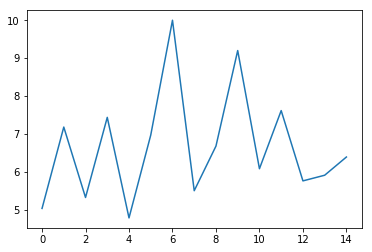

In [140]:
plt.figure()
plt.plot(List_Q)
plt.show()

In [131]:
df_new.shape

(2261750, 5)

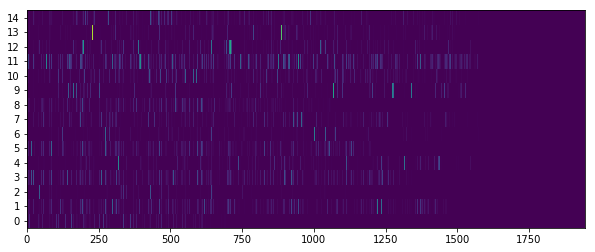

In [118]:
#Topics by user
plt.figure(figsize=(10,4))
plt.pcolormesh(A.T)#, cmap=plt.cm.Greys)
plt.xlim(0,A.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(0,B.shape[1]+1))
#plt.savefig('Topic_bybin_normalized.pdf')
plt.show()

In [119]:
fav_topics=[]
for user in A:
    user=list(user)
    tp_fav=user.index(max(user))
    fav_topics.append(tp_fav)

In [120]:
tp_histo=[]
for tp in set(fav_topics):
    tph=0
    for f in fav_topics:
        if f==tp:
            tph+=1
    tp_histo.append(tph)

In [121]:
for i,j in enumerate(tp_histo):
    print(i,j)

0 746
1 99
2 14
3 112
4 54
5 103
6 33
7 39
8 94
9 48
10 99
11 327
12 63
13 36
14 78


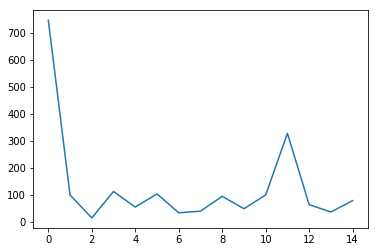

In [128]:
plt.figure()
plt.plot(tp_histo)
plt.show()

In [130]:
TermVectorsIndex[11]

[('sempre', 14.54321517568269),
 ('quando', 13.995582228457254),
 ('fa', 13.760403433671636),
 ('mai', 12.040732606764786),
 ('poi', 11.748700027779021),
 ('essere', 11.626662774336316),
 ('via', 11.608093584594016),
 ('fare', 11.464558500711087),
 ('vita', 10.626826436441975),
 ('ancora', 10.618852844194047),
 ('cè', 10.457375231204743),
 ('ora', 10.045318265481619),
 ('senza', 10.035205548568062),
 ('così', 9.985436290111306),
 ('anni', 9.94487713035242),
 ('grazie', 9.722126519952432),
 ('prima', 9.450474585407937),
 ('fatto', 9.278089861492818),
 ('già', 8.920518235618824),
 ('due', 8.905059364619689),
 ('po', 8.436736691409823),
 ('dopo', 8.365620620514694),
 ('bene', 7.960094734877627),
 ('nuovo', 7.9000139546200145),
 ('casa', 7.702547330453449),
 ('grande', 7.591336269890838),
 ('foto', 7.255927090254057),
 ('mondo', 7.156991671776354),
 ('cose', 7.135224042962333),
 ('giorno', 7.072817084238714),
 ('tempo', 7.069336585817015),
 ('stato', 6.726870364502047),
 ('va', 6.686619890

In [141]:
f=open(path+'TermVectors.txt','w')
for tvi in TermVectorsIndex[::-1]:
    f.write(str(TermVectorsIndex.index(tvi))+ ' '+str([t[0] for t in tvi[0:10]])+'\n')
f.close()

pickle.dump(A, open(path+'pickle/A.pkl','wb'))
pickle.dump(B, open(path+'pickle/B.pkl','wb'))
pickle.dump(C, open(path+'pickle/C.pkl','wb'))
#pickle.dump(Coordinates, open(path+'pickle/Grid.pkl','wb'))
f = open(path+'pickle/Vocabulary.csv', 'w')
for item in feature_names:
    f.write("%s\n" % item.encode('utf-8'))
f.close()

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


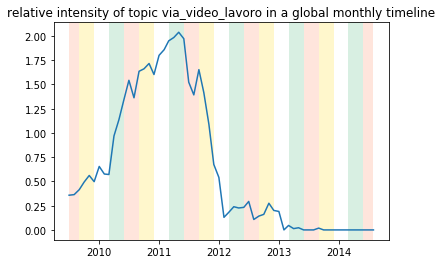

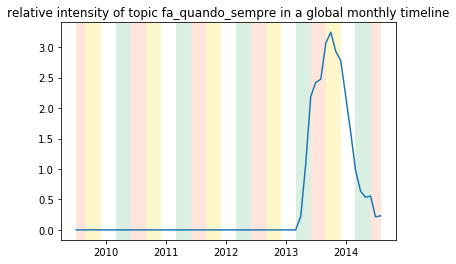

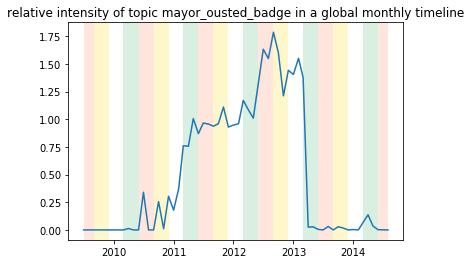

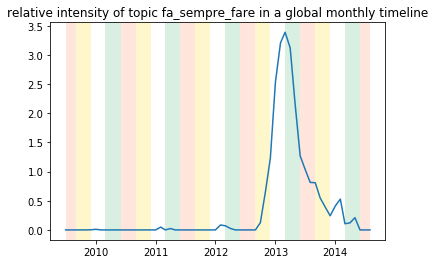

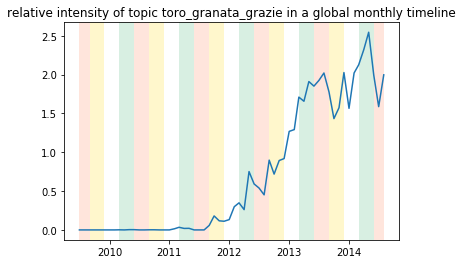

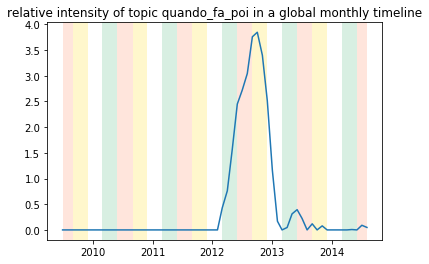

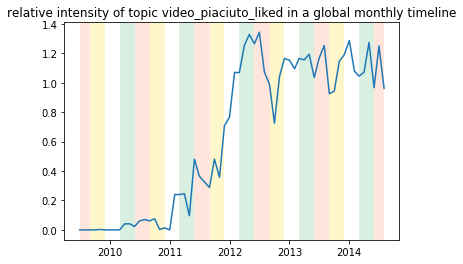

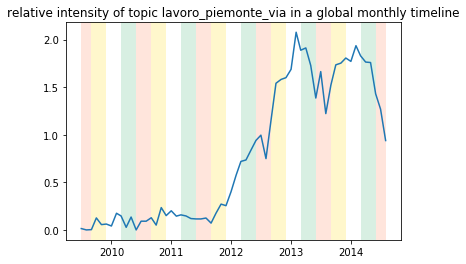

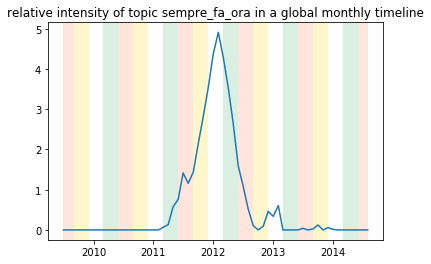

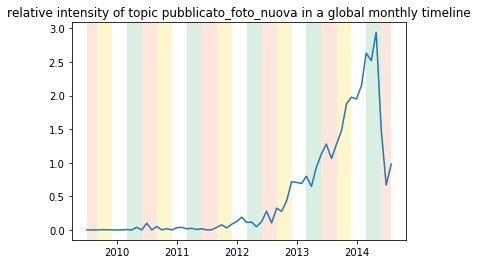

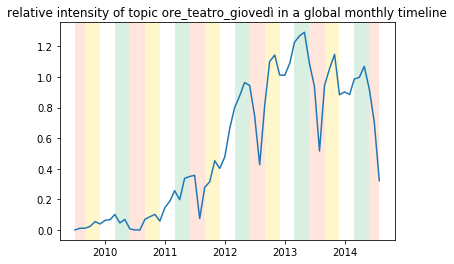

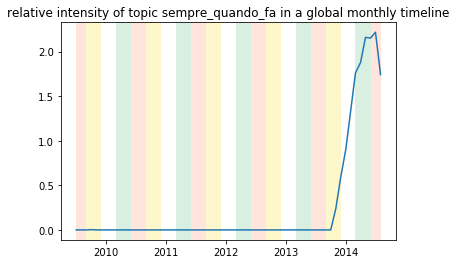

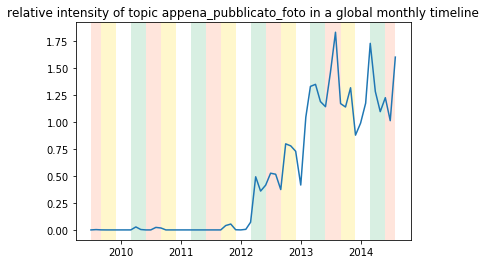

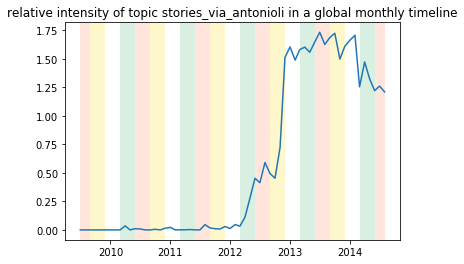

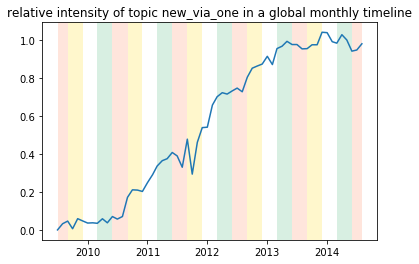

In [142]:
importlib.reload(IL)
importlib.reload(IP)
#msg='Set of Heatmaps made on the 24/01, sampled from April 2013. First run to be made with 17 TV. with Monuments'
#foldername1='Heatmaps_2401_17_spl'
#foldername2='NTF_2401_17_spl'


# Time Series    
seasons=['white', 'mediumseagreen', 'coral', 'gold']
for index in range(0, len(C.T)):
    row=C.T[index]
    topic=''
    for i in (0,1,2):
        topic+=TermVectorsIndex[index][i][0]+'_'
    topic=topic.strip('_')
    plt.figure()
    plt.plot(flags[start:][0:len(row)], row)
    plt.xticks(flags[start:stop][[f.date().month for f in flags[start:stop]].index(1)::12])
    for i in range(0, len(flags[start:stop])-1):
        season=seasons[int(((int(str(flags[start+i].date()).split('-')[1])-3)/3+1)%4)]
        plt.axvspan(flags[start+i],flags[start+i+1], facecolor=season, alpha=0.2)
    plt.title('relative intensity of topic '+topic+' in a global monthly timeline')
    if True:
        plt.savefig(path+'t_series/plot_topic_'+topic+'.pdf')
    plt.show()

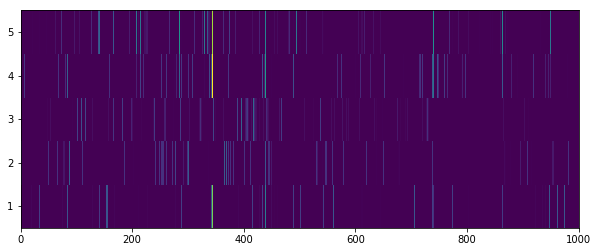

In [109]:
#Topics definition
plt.figure(figsize=(10,4))
plt.pcolormesh(B.T)#, cmap=plt.cm.Greys)
plt.xlim(0,B.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(1,B.shape[1]+1))
#plt.savefig('Topic_definition_normalized.pdf')
plt.show()

#for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
#    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

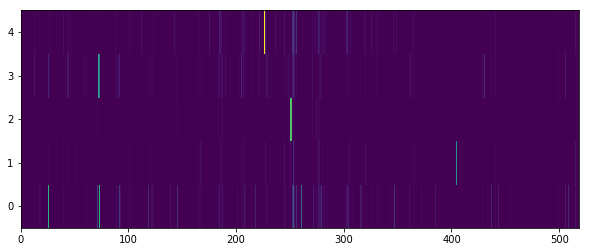

4 [u'fumett', u'comics', u'fumetter', u'nerd', u'epic']
3 [u'cosplay', u'comics', u'cosplayer', u'xmascomics', u'mang']
2 [u'mua', u'makeupartist', u'makeup', u'mbacademy', u'makeuplover']
1 [u'tatto', u'comics', u'ink', u'inked', u'tattooart']
0 [u'cosplay', u'cosplayer', u'comics', u'phot', u'anim']


In [127]:
#Topics by bin
plt.figure(figsize=(10,4))
plt.pcolormesh(A.T)#, cmap=plt.cm.Greys)
plt.xlim(0,A.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(0,B.shape[1]+1))
#plt.savefig('Topic_bybin_normalized.pdf')
plt.show()

for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

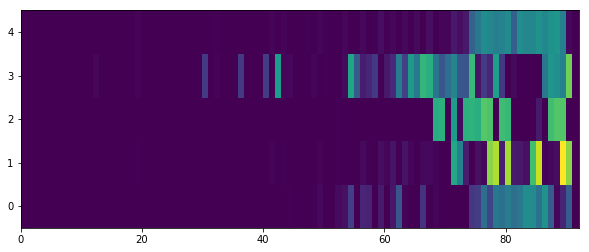

4 [u'fumett', u'comics', u'fumetter', u'nerd', u'epic', u'comicbook']
3 [u'cosplay', u'comics', u'cosplayer', u'xmascomics', u'mang', u'anim']
2 [u'mua', u'makeupartist', u'makeup', u'mbacademy', u'makeuplover', u'makeupaddict']
1 [u'tatto', u'comics', u'ink', u'inked', u'tattooart', u'tattooartist']
0 [u'cosplay', u'cosplayer', u'comics', u'phot', u'anim', u'xmascomics']


In [125]:
#Topics Dynamics
plt.figure(figsize=(10,4))
plt.pcolormesh([c for c in C.T])#, cmap=plt.cm.Greys)
plt.xlim(0,len(C.T[0]))
#plt.savefig('Topic_dynamic.pdf')
plt.yticks(np.arange(n_topics)+0.5, np.arange(0,n_topics));
#plt.xticks(flags[start:stop])
plt.show()
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:6]]

In [65]:
foldername='Word2vec_TFF'
if foldername not in os.listdir('PKL_files/results/'):
    os.mkdir('PKL_files/results/'+foldername)
foldername='PKL_files/results/'+foldername
pickle.dump(A, open(foldername+'/A.pkl','wb'))
pickle.dump(B, open(foldername+'/B.pkl','wb'))
pickle.dump(C, open(foldername+'/C.pkl','wb'))
pickle.dump(Coordinates, open(foldername+'/Grid.pkl','wb'))
f = open(foldername+'/Tortest_inst_spl.csv', 'w')
for item in feature_names:
    f.write("%s\n" % item.encode('utf-8'))
f.close()

In [148]:
seasons

['white', 'green', 'red', 'orange']

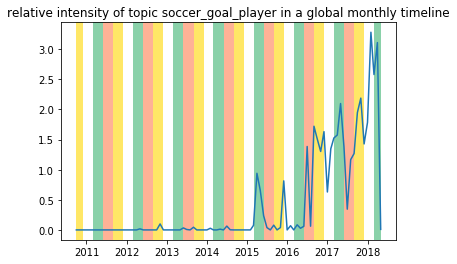

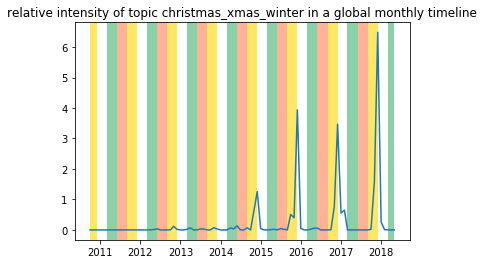

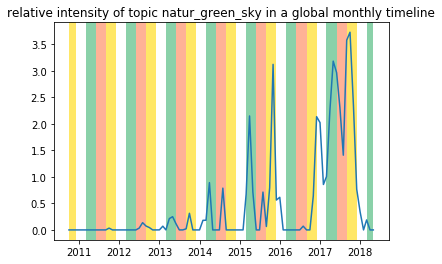

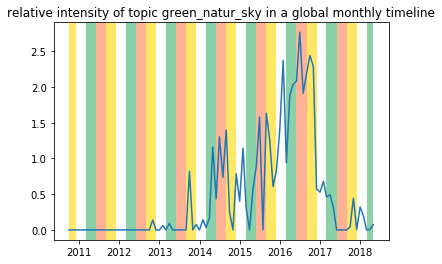

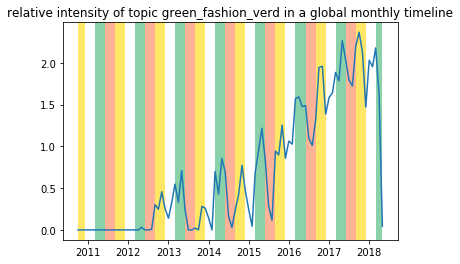

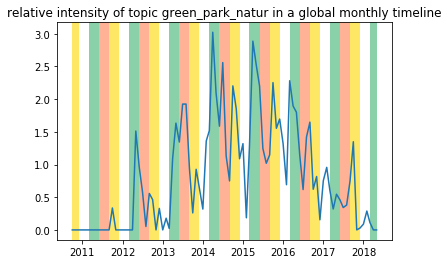

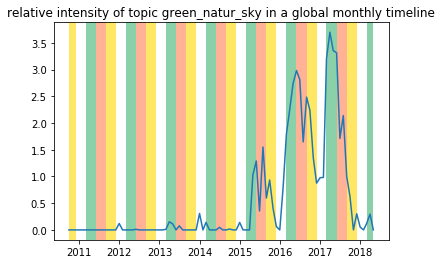

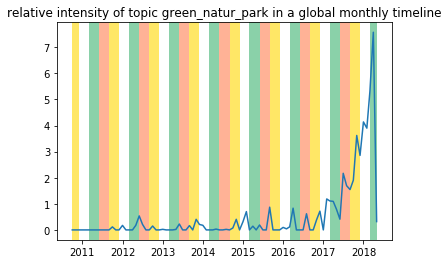

In [156]:
#foldername='Heatmaps_2401_17_noMon'
for index in range(0, len(C.T)):
    row=C.T[index]
    topic=''
    for i in (0,1,2):
        topic+=TermVectorsIndex[index][i][0]+'_'
    topic=topic.strip('_')
    plt.figure()
    plt.plot(flags[start:][0:len(row)], row)
    plt.xticks(flags[start:stop][3::12])
    plt.title('relative intensity of topic '+topic+' in a global monthly timeline')
    for i in xrange(len(flags[start:stop])-1):
        season=seasons[((int(str(flags[start+i].date()).split('-')[1])-3)/3+1)%4]
        plt.axvspan(flags[i],flags[i+1], facecolor=season, alpha=0.6)
        
    if False:
        if foldername not in os.listdir('Figures/Heatmaps/'):
            os.mkdir('Figures/Heatmaps/'+foldername)
        plt.savefig('Figures/Heatmaps/'+foldername+'/plot_topic_'+topic+'.pdf')
    plt.show()

In [9]:
dfa = pd.DataFrame(A).groupby(voc_serie).sum()
#dfa = dfa[dfa.index!='teachers']

NameError: name 'A' is not defined

In [ ]:
plt.figure(figsize=(10,4))
plt.pcolormesh(C.T)#, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(np.arange(14)+0.5, np.arange(1,15));

In [31]:
lang = detect("Ein, zwei, drei, vier")
# it for italian, en for english
class StemmedCountVectorizer(CountVectorizer):
    # This class is basically a CountVectorizer class that has been enhanced with a stemmer method.
    def build_analyzer(self):
        #Use super to access the method build_analyzer form the class CountVectorizer.
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        #return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        return lambda doc: ([self.stemmer(w) for w in analyzer(doc)])
    
    def stemmer(self, w):
        if langid.classify(w)=='it':
            return italian.stemmer(w)
        elif langid.classify(w)=='en':
            return english.stemmer(w)
        else:
            return w
        
    def language_detector(w):
        try:
            return langid.classify(w)[0]
        except LangDetectException:
            return 'emoji'
    importlib.reload(IL)

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
df_new_index.date=[str(d) for d in df_new_index.date.tolist()]

/home/eartiges/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [24]:
df_new_index

,date,text,coordsbin,year_month,month_abs
user_id,,,,,
1026198161637957632,2019-02-21 20:30:36,Buonanotte a tutti amici Twitter,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-21 16:52:34,Buona serata e buona cena a tutti amici Twitter,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-21 12:09:11,Buon pranzo a tutti amici Twitter,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-21 05:42:40,Grazie buongiorno anche a te,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-21 05:35:30,Grazie buongiorno anche a te,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-20 17:09:45,Buona serata a tutti,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-20 16:56:54,Buona serata e buona cena a tutti amici Twitter,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-20 11:45:20,Buon pranzo e buon pomeriggio a tutti amici Tw...,"(45.0945, 7.583845590959271)","(2019, 2)",146
1026198161637957632,2019-02-20 05:39:28,Grazie buona giornata anche a te,"(45.0945, 7.583845590959271)","(2019, 2)",146


In [22]:
df_word2vec=IL.df_seeding(df_new_index, 'coucou')

AttributeError: 'tuple' object has no attribute 'split'

In [ ]:
start=30
stop=92
#MATLAB says up to 15 terms we still have a core consistency above 60% without sampling. 
#at 16, the CC already varies a lot (between 3 ad 50%)
#For sampled, up to 17 terms seems to be OK.
n_topics=15
n_features=5000

sampling=False
mat_export=True
seeded=False
expanded=False

seed='pittura'

#Filter out the monuments?
monuments=False

df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')

all_stopwords=IL.stopwords(monuments)

if seeded and not expanded:
    df_word2vec=IL.df_seeding(df_new_index, seed)
    list_reviews_all=df_word2vec.result.tolist()
elif expanded:
    df_word2vec=IL.df_expanded_seeding(df_new_index, seed,model=model_1)
    list_reviews_all=df_word2vec.result.tolist()
else:
    list_reviews_all=df_new_index.result.tolist()

#Build the vectorizer and the list of all words in the dataset
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords)     
while '' in list_reviews_all:
    list_reviews_all.remove('')
while "" in list_reviews_all:
    list_reviews_all.remove("")

In [32]:
df_new=pd.read_pickle('df_new_chkpt5.pkl')
df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

In [33]:
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=IL.all_stopwords)     


In [34]:
counts_all = vectorizer_s.fit_transform(list_reviews_all)

/home/eartiges/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lamiacitt', 'torinoã'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [8]:
list_years=[i for i in range(2010,2018)]

In [35]:
import scipy.io
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.io import savemat
n_features=1000
n_topics=10

list_reviews_all=df_new_index['text'].tolist()
#counts= vectorizer_s.fit_transform(list_reviews_all)
vectorizer_new = CountVectorizer(max_df=0.95, max_features=n_features,stop_words=IL.all_stopwords,vocabulary=vectorizer_s.vocabulary_)
ct=0

# For each month in the dataset, get a snapshot view of the NMF tensor:
for month in range(1,max(df_new_index.month_abs),3):
    
    year_start=list_years[0]+ int(month/12)
    month_start=month%12  
    year_end=list_years[0]+ int(month+11-0.5)/12
    month_end=1+(month+11-1)%12
    
    list_reviews_rest=df_new_index[df_new_index.month_abs==month].text.tolist()
    if len(list_reviews_rest)<n_topics:
        continue
    # Learn the vocabulary dictionary and return term-document matrix.
    counts = vectorizer_new.fit_transform(list_reviews_rest)
    
    #Transform a count matrix to a normalized tf-idf representation. 
    #(mainly =Terms with frequencies too hi or lo are removed)
    tfidf = TfidfTransformer().fit_transform(counts)
    
    #Save the data in matlab friendly format
    savemat('Inst500Matr' + str(ct), {'tfidf':tfidf})
    
    
    nmf = decomposition.NMF(n_components=n_topics)
    
    #We are looking for two matrices whose product approximates tfidf.
    
    # Learn the model (parameters etc.). I.e "take a look at what we have". returns nothing.
    W = nmf.fit(tfidf)
    
    # dictionary (factorization matrix)
    H = nmf.components_
    
    # Extracts the data and performs NMF on the tfidf-treated dataset. 
    # Returns the matrix W (the weight matrix), to be multiplied by the matrix H (dictionary) to get target tfidf.
    X2 = nmf.fit_transform(tfidf)
    ct=ct+1
    feature_names = vectorizer_new.get_feature_names()
    print ('month', month)
    for i,text_topic in enumerate(X2.T):
        
        # i.e -> i, [content of column i of X2]
        # i-th topic named text_topic
        text_top = text_topic.argsort()[:-21:-1]
        word_top = nmf.components_[i].argsort()[:-11:-1]
        
        # For each text topic in the NMF resulting list, print the weight vector and the term vector.
        print ([nmf.components_[i,k] for k in nmf.components_[i].argsort()[:-11:-1]][0:4])
        print (", ".join([feature_names[i] for i in word_top][0:8]))
        
        # print the amount of non-zero components in the weight vector
        l=[text_topic[i] for i in text_top]
        print (np.count_nonzero(l))
            

month 1
[0.9716285138668512, 0.5243694451690054, 0.49457427751507727, 0.2749996281886331]
casa, vado, arrivo, web, settimana, sento, finalmente, dopo
4
[1.0351213586237982, 0.4666635580813654, 0.0, 0.0]
ritorno, mattina, من, già, grazie, grandi, grande, gran
2
[0.6770301877430147, 0.5520503978813963, 0.3878926123990389, 0.2919520300692751]
poi, po, culo, merda, mettere, dopo, finalmente, vado
4
[0.9365031448006157, 0.33114343567534826, 0.33114343567534826, 0.33114343567534826]
pranzo, aperto, forse, ora, going, great, grazie, grandi
2
[0.8550834064909104, 0.4838354307219648, 0.4838354307219648, 0.0]
fine, preso, mese, gruppo, great, grazie, grandi, grande
2
[0.5198511469917374, 0.46980709314566954, 0.46980709314566954, 0.46980709314566954]
cazzo, mai, ok, francesco, dopo, finalmente, vado, culo
3
[0.8235047056044406, 0.8235047056044406, 0.0, 0.0]
video, youtube, giveaway, grazie, grandi, grande, gran, governo
1
[0.6459175729109705, 0.6459175729109705, 0.0, 0.0]
mondo, twitter, من, go, 

month 46
[1.393891755070547, 0.1651119132258699, 0.14129380706390254, 0.14082226096908024]
via, twitter, state, firenze, take, due, business, part
18
[0.9179287368913426, 0.6313035066565453, 0.6313035066565453, 0.2995890539108634]
video, piaciuto, youtube, ora, time, link, first, new
10
[1.200091297554619, 0.39392908856360936, 0.272073559833298, 0.26635478486828607]
im, ive, milano, firenze, due, festival, aprile, old
12
[1.0951096911306202, 0.6706327590260208, 0.23627596770618242, 0.22046031783875603]
sito, twitter, meno, avere, ok, pagina, euro, molto
9
[1.0910038210266493, 0.4283214247998829, 0.32460913251122164, 0.09025660903999025]
pranzo, domani, cuore, martedì, finito, ah, giorni, casa
20
[0.9361370937002843, 0.8281956236336303, 0.09106362140883262, 0.09106362140883262]
day, th, going, old, family, ive, ora, city
14
[1.6649934739159717, 0.1716731718443268, 0.1716731718443268, 0.12556595222108974]
check, coming, tour, web, future, design, via, foto
20
[0.9104821144179396, 0.30786

[1.2282175791614445, 0.3069617978915505, 0.28149673481857856, 0.24752969718662676]
ora, nuovo, twitter, ok, casa, quando, va, quindi
20
month 64
[1.4383460777483885, 1.2926872658688109, 1.2655831260493295, 0.6712284806253751]
new, facebook, posted, video, photo, pubblicato, digitale, nuova
20
[1.3576467802019574, 1.3439402914789922, 1.295617539763744, 0.04576960361387009]
pubblicata, foto, appena, pubblicato, parco, piazza, nuova, facebook
20
[2.17280132374635, 0.21513487922975794, 0.049930542783776226, 0.04707365390854769]
im, piemonte, soon, starwars, parco, tre, festival, see
20
[1.3651650658241195, 1.274505171448544, 0.2084885533054051, 0.08173277257910727]
video, piaciuto, official, aggiunto, time, casa, pace, full
20
[2.1019077609436243, 0.26835101827665087, 0.16152057677874357, 0.13981743195605606]
grazie, mille, mai, bello, cuore, grande, domani, aver
20
[1.5753279655163202, 0.8431734903672254, 0.5190755895197354, 0.3836112014449079]
supercell, part, us, may, storm, looking, ne

month 82
[1.797314872619079, 1.7499686445566773, 0.06623301526881996, 0.06472285014974771]
novità, ultime, alto, sicilia, sai, volte, speriamo, pd
20
[2.589517439092374, 0.2963165508043874, 0.12478595905226308, 0.11011735009789698]
via, stampa, trailer, ufficiale, stories, fare, win, photo
20
[1.4338116022061453, 1.2742236175529993, 1.0074793878230772, 0.8741174173777487]
foto, pubblicato, facebook, nuova, appena, nellalbum, san, ottobre
20
[2.2109977160377494, 0.5379450405323725, 0.23000031178292202, 0.18692550415212555]
favorited, mixcloud, milano, dj, disco, need, live, amp
20
[1.9019296264449614, 1.0858770801800097, 0.280517754007014, 0.15399490533270938]
video, piaciuto, liked, massimo, halloween, live, official, amp
20
[1.405446502153981, 1.320941231349674, 0.7709322891088206, 0.5562594064335944]
francesco, antonioli, stories, top, today, politica, prossima, one
20
[1.553693049128925, 1.5264921579193274, 0.10877129741261445, 0.07423321854801261]
parrot, palm, home, casa, hallowee

month 100
[2.6401039693253523, 0.19178581939741665, 0.18528098534502638, 0.13017101279571547]
im, sede, palazzo, caffè, vs, bar, hawaii, club
20
[2.644195652733361, 0.15753064690485669, 0.12634334836627453, 0.1201714940216935]
via, smart, stampa, city, argotec, spazio, stato, secondo
20
[1.5685361450941724, 1.3061691514381097, 0.9627862406744748, 0.5233750429064651]
foto, pubblicato, facebook, appena, nuova, nellalbum, stampa, eventi
20
[1.868307965211179, 1.5621900623170404, 0.19990537421832025, 0.13570285819728228]
video, piaciuto, vs, argotec, doctor, nuovo, back, liked
20
[2.2190611908346685, 0.3853612019078624, 0.2521871720392441, 0.16120099425078457]
milano, piazza, expo, qualcuno, verso, work, milan, sky
20
[2.1362931405855874, 0.1739661695779147, 0.14159023766571646, 0.12327909813193881]
new, argotec, amp, time, radio, week, black, grande
20
[2.3314703568676887, 0.19521222914861153, 0.16156865211729798, 0.15136430182950633]
grazie, ora, bella, casa, fim, davvero, parla, mille
2

month 118
[2.2157733931311285, 1.6706044127745319, 1.5872636843815846, 0.18707648974193353]
via, spreaker, ascolta, diretta, real, amp, linea, trailer
20
[1.9950647084224635, 1.9808144214483692, 0.36108775620688177, 0.23057280179143186]
mancano, fondamentali, sempre, bello, mondo, essere, ancora, far
20
[1.638579965418147, 1.5127571770049364, 1.4487024047807697, 1.0313787322169976]
online, prezzi, torinofinestre, porteinterne, infissi, prezzifabbrica, provincia, città
20
[1.6154023238415853, 1.3689629846344196, 1.3667217433545895, 1.255474445789847]
foto, facebook, pubblicato, nuova, nellalbum, grazie, quando, porta
20
[1.8837623708354536, 1.8660820758759908, 0.08358710858956447, 0.07472441238438907]
posted, photo, parco, corso, san, centro, piazza, museo
20
[3.07248707287764, 0.38477018195603907, 0.373409421389605, 0.252628455869158]
ottobre, venerdì, lunedì, martedì, giovedì, sabato, ore, mercoledì
20
[1.9252839745865982, 1.9086118609323932, 0.06481296387259056, 0.0539492173991369]
l

month 136
[2.809691844099496, 0.2649293629957562, 0.18446410496717908, 0.1590005741397075]
tedtalks, people, rt, new, life, us, want, time
20
[3.0152288168709704, 0.11329550387292499, 0.10910577825215052, 0.10361826813373108]
amici, eh, maria, grazie, marco, ciao, vita, buona
20
[2.7990023923035516, 0.15670040970950863, 0.15141630291384253, 0.14468368403394347]
aprile, maggio, festa, sabato, buon, nuovo, città, domenica
20
[1.9216712666608469, 1.8937173391156688, 0.06336401366220479, 0.05294116490483672]
lifestyle, nr, primavera, torinese, vista, punto, tempo, bella
20
[2.261645138677839, 0.4263911497362293, 0.35649573901397363, 0.3507358332240401]
via, episodio, stories, ubezio, pierluigi, daily, ascolta, antioca
20
[1.7377359429774095, 1.4329329756882327, 1.376442574174268, 0.06271973383307858]
foto, appena, pubblicata, centro, libro, isola, fa, hotel
20
[1.7526238250340962, 1.6338077469457346, 0.8671558224723845, 0.26820718746058664]
im, roma, rome, rincones, maggio, club, amp, mila

In [15]:
df_new_index[df_new_index.month_abs==month]

,date,text,coordsbin,year_month,month_abs
user_id,,,,,
700413,2007-07-31 07:34:36,change powertrain PDD,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-27 08:47:01,faccio finta di monitorare gli ias di fiat,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-26 13:10:26,bestemmio contro hpux i,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-26 13:00:02,installo IAS per fiat,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-06 05:51:41,cazzeggio facendo colazione,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-05 12:32:17,leggo il protocollo della prossima americas cup,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7
700413,2007-07-03 22:57:59,cazzo ma non funzioni mai,"(45.031499999999994, 7.634829426864879)","(2007, 7)",7


In [ ]:
>>> import numpy as np
>>> X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
>>> from sklearn.decomposition import NMF
>>> model = NMF(n_components=2, init='random', random_state=0)
>>> W = model.fit_transform(X)
>>> H = model.components_

In [ ]:
X

In [ ]:
for i, t in enumerate(X):
    print i,t

In [ ]:
print feature_names

In [ ]:
#save the feature names in a csv file
type(feature_names)
import io

f = io.open('test_inst_Torino.csv', 'w', encoding='utf8')
for item in feature_names:
    print item
    f.write("%s\n" % item)

In [ ]:
#Boundaries of the map
print (df_new['lonbin'].min()-step_lon/2., df_new['latbin'].min()-step_lat/2., df_new['lonbin'].max()+step_lon/2., df_new['latbin'].max()+step_lat/2)

In [ ]:
len(df_new_nodup_cells['n'].unique())
list_rc=df_new_nodup2_cells['n'].tolist()
with open('n_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_rc))

In [ ]:
list_rc

In [ ]:
df_new_nodup2_cells

In [ ]:
df_new_nodup2_cells.head()

In [ ]:
import time
import datetime
list_time=[]
for month in range(1,(len(list_years)-1)*12+2,3):
        year_start=list_years[0]+ int(month/12)
        month_start=month%12  
        year_end=list_years[0]+ int(month+11-0.5)/12
        month_end=1+(month+5-1)%12
             
     
        if month_end in([2,4,6,9,11]):
            day=30
        else:
            day=31
        deb=str(year_start) + '-' + str(month_end) + '-1'
        deb_new=time.mktime(datetime.datetime.strptime(deb, "%Y-%m-%d").timetuple())
        if month==1:
            list_time= np.append(deb_new,list_time)
        else:
            list_time=np.append(list_time,deb_new)


In [ ]:
print list_time

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

In [150]:
vectorizer = CountVectorizer()
corpus = ['This is the first document.',
     'This is the second second document.',
     'And the third one.',
          '',
          '',
     'Is this the first document?']
X_vec = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X_vec.toarray()      
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
X_fidf = transformer.fit_transform(X_vec.toarray())
print X_fidf.toarray()

[[0.         0.43746414 0.54222553 0.43746414 0.         0.
  0.36313476 0.         0.43746414]
 [0.         0.26203538 0.         0.26203538 0.         0.86411832
  0.21751303 0.         0.26203538]
 [0.55440642 0.         0.         0.         0.55440642 0.
  0.27910674 0.55440642 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.43746414 0.54222553 0.43746414 0.         0.
  0.36313476 0.         0.43746414]]


In [ ]:

with open('times_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_time))

In [ ]:
Text_tot=[]

if sampling:
    for month in snapshots[start:stop]:
        Text=df_classified[month].tolist()
        #Split the posts: how many of them do we have in each bin?
        list_reviews_rest = [len(a.split(',')) for a in Text]
        #Which bins have info?
        list_indices_info=[Text.index(a) for a in Text if a!='']
        #If we have more posts this month than in the reference month
        if threshold<len(list_reviews_rest):
            #On a bin with info...
            choices=[np.random.choice(list_indices_info) for i in xrange(threshold)]
            #...Pick a tweet among those there.
            choices =[(e,np.random.randint(0,list_reviews_rest[e])) for e in choices]
            This_Month=['' for i in Text]
            for tweet in choices:
                This_Month[tweet[0]]+=Text[tweet[0]].split(',')[tweet[1]]+','
            Text_tot.append(This_Month)
        else:
            Text_tot.append(Text)
            
for month in snapshots[start:stop]:
    ct+=1
    print flags[snapshots.index(month)]
    try:
        if sampling:
            This_Month=Text_tot
        else:
            This_Month=df_classified[month].tolist()